# 기본

In [53]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [54]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [55]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [ ]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

area = ['서울특별시','부산광역시','대전광역시','대구광역시']
ind = train_one.loc[-train_one['지역'].isin(area),:].index
train_one.loc[ind,'환승역 수'] = 0

ind = test_one.loc[-test_one['지역'].isin(area),:].index
test_one.loc[ind,'환승역 수'] = 0

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [56]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [57]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [58]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [59]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [60]:
level = 85

In [61]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [62]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [63]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [64]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [65]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [66]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [67]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [68]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [69]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [70]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [71]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [72]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [73]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [74]:
area = ['서울특별시','부산광역시','대전광역시','대구광역시']
ind = train_one.loc[-train_one['지역'].isin(area),:].index
train_one.loc[ind,'환승역 수'] = 0

In [75]:
ind = test_one.loc[-test_one['지역'].isin(area),:].index
test_one.loc[ind,'환승역 수'] = 0

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [76]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [77]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [78]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

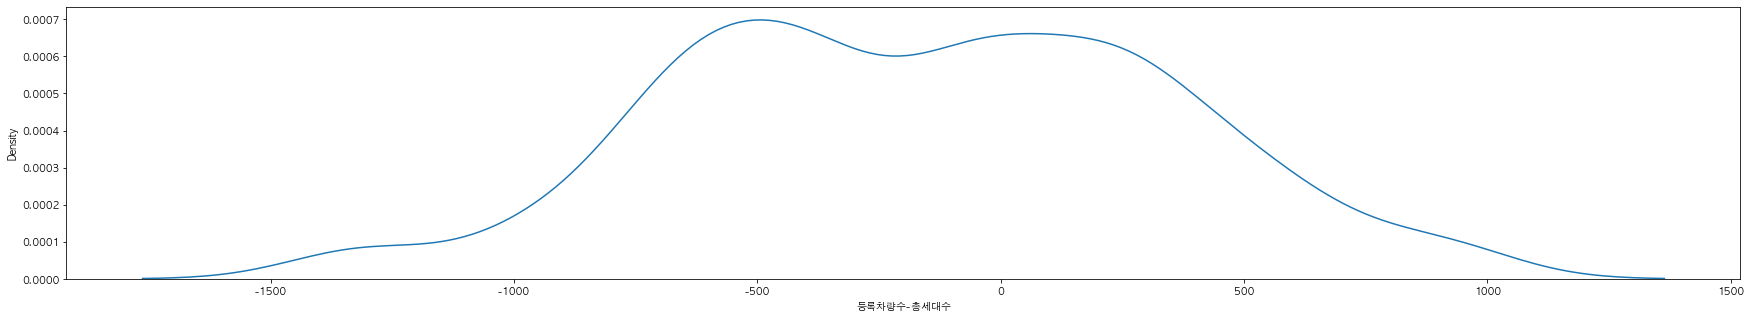

In [79]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

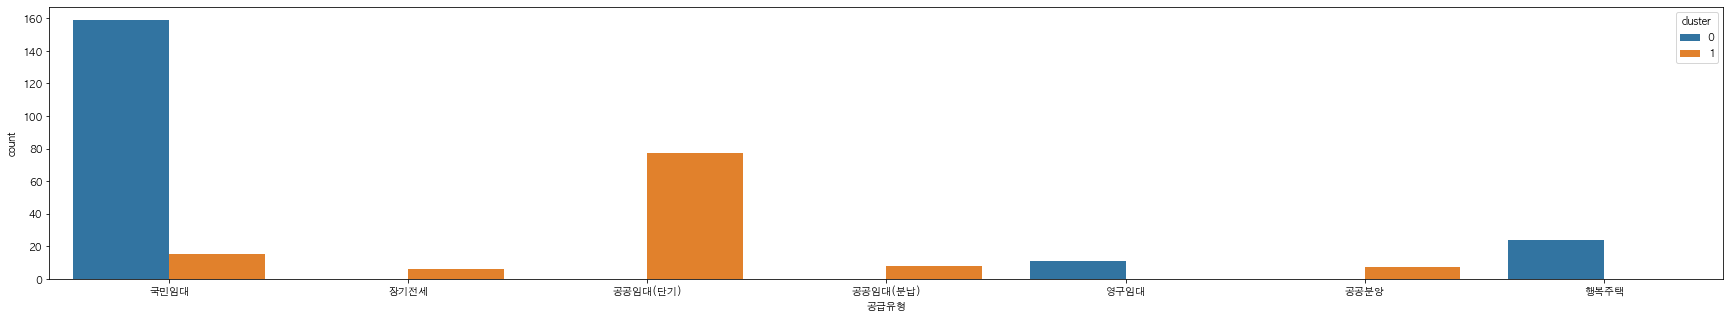

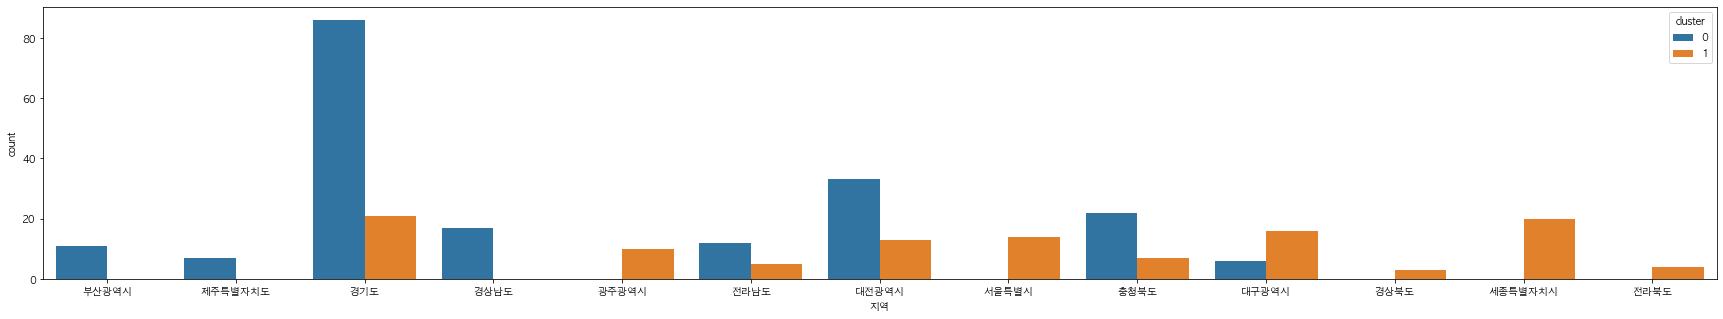

In [80]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [81]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [82]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [83]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [85]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [86]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [87]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  107.15364835332579


<AxesSubplot:>

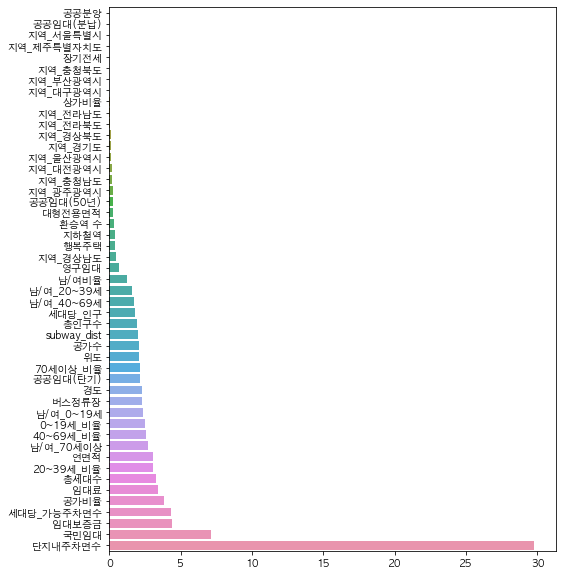

In [88]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))


### 2) train/test up

In [89]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

# cb_up =  ElasticNet(random_state=2021)
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
models2 = [
     CatBoostRegressor(random_state=2021, loss_function = 'MAE')
#     ,
#          ElasticNet(random_state=2021)
]

model_up2,pred_up2,error_up2 = fit_models(X, y, models2, cv=True)
print('MAE : ',error_up2)

MAE :  297.8681914688521


In [90]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error

from sklearn.preprocessing import StandardScaler
def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [91]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

# cb_up =  ElasticNet(random_state=2021)
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
models1 = [
    Lasso(random_state=2021)
#      CatBoostRegressor(random_state=2021, loss_function = 'MAE')
#     ,
#          ElasticNet(random_state=2021)
]

model_up1,pred_up1,error_up1 = fit_models(X, y, models1, cv=True)
print('MAE : ',error_up1)

MAE :  349.25053345129777


/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3872.651412462583, tolerance: 855.0249121951219
  model = cd_fast.enet_coordinate_descent(
/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4865.68789633445, tolerance: 736.9706
  model = cd_fast.enet_coordinate_descent(
/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1344.4719039432239, tolerance: 1021.827623076923
  model = cd_fast.enet_coordinate_descent(


<AxesSubplot:>

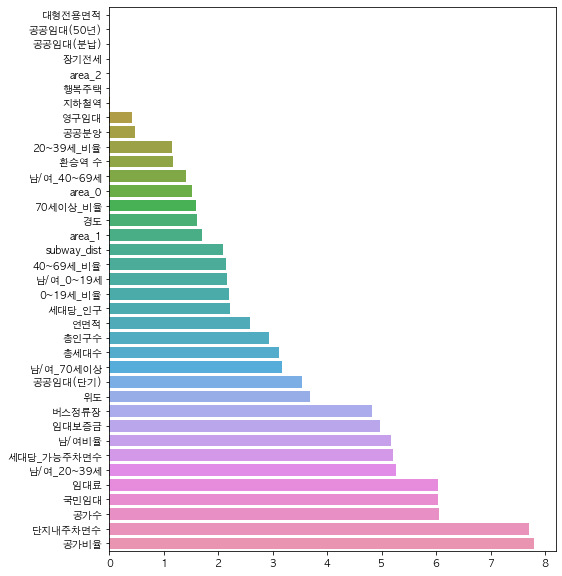

In [92]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up2.feature_importances_)], x = list(model_up2.feature_importances_[np.argsort(model_up2.feature_importances_)
                                                                                                            ]))

NameError: name 'model_up' is not defined

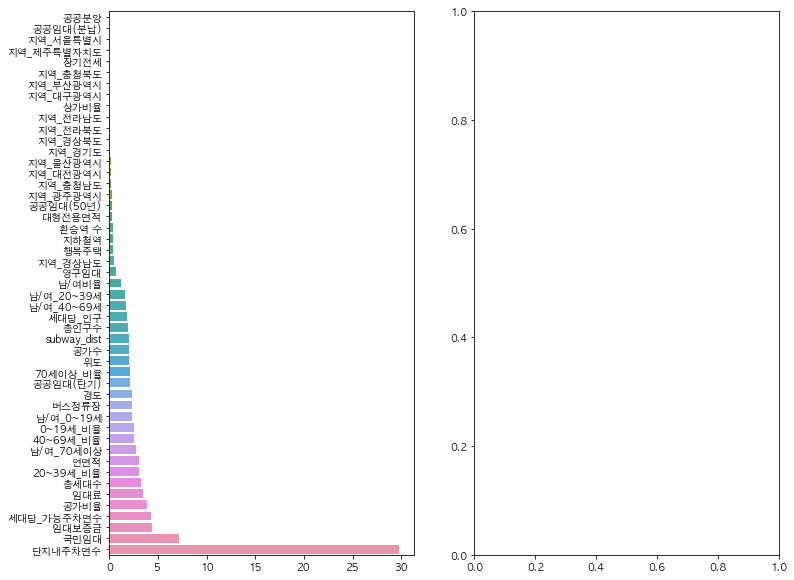

In [93]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))
plt.subplot(1,2,2)
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))                                                                                     
plt.show()

In [94]:
#Lasso
best_tst_pred2 = pred_up1
col = ["단지코드","공가비율","단지내주차면수","국민임대","임대료","남/여_20~39세","남/여비율","임대보증금","버스정류장","위도","공공임대(단기)","남/여_70세이상","총세대수","총인구수","연면적"]
tst_pred2 = pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred2 = pd.merge(tst_pred2, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")
tst_pred2["diff"] = tst_pred2["등록차량수"]-tst_pred2[0]

In [95]:
#Catboost
best_tst_pred3 = pred_up2
col = ["단지코드","공가비율","단지내주차면수","국민임대","임대료","남/여_20~39세","남/여비율","임대보증금","버스정류장","위도","공공임대(단기)","남/여_70세이상","총세대수","총인구수","연면적"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = pd.merge(tst_pred3, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")
tst_pred3["diff"] = tst_pred3["등록차량수"]-tst_pred3[0]

In [96]:
mc1 = tst_pred2[["등록차량수",0,"diff","단지내주차면수","공가비율","단지코드"]]
mc1["new"] = list((1- mc1.loc[:,"공가비율"])*mc1.loc[:,"단지내주차면수"])
mc1 = mc1.sort_values("등록차량수").reset_index(drop=True)
mc1

<ipython-input-96-6277839fe863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc1["new"] = list((1- mc1.loc[:,"공가비율"])*mc1.loc[:,"단지내주차면수"])


등록차량수            0         diff  단지내주차면수      공가비율   단지코드          new
0    196.0   824.633448  -628.633448   1055.0  0.030484  C2362  1022.839629
1    579.0   788.535123  -209.535123   1110.0  0.019910  C2377  1087.900452
2    619.0   495.482538   123.517462   1493.0  0.037012  C1176  1437.740915
3    657.0   836.281428  -179.281428   1129.0  0.025801  C1236  1099.870996
4    713.0   814.042259  -101.042259   1182.0  0.030303  C2274  1146.181818
5    733.0  1067.275569  -334.275569   1154.0  0.021838  C1863  1128.798908
6    783.0  1130.700659  -347.700659   1319.0  0.025806  C2618  1284.961290
7    795.0   624.080608   170.919392   1082.0  0.016154  C2000  1064.521538
8    799.0  1194.612039  -395.612039   1299.0  0.008826  C2538  1287.535642
9    839.0   812.410828    26.589172   1296.0  0.020874  C1430  1268.947162
10   873.0   980.281028  -107.281028   1043.0  0.011111  C1672  1031.411111
11   881.0  1319.264541  -438.264541    988.0  0.029380  C1286   958.972797
12   886.0  1118.936704  -232.936704   1192.0  0.021230  C1969  1166.693997
13   922.0  1564.821251  -642.821251   1176.0  0.000647  C2393  1175.239327
14   924.0  1389.357969  -465.357969   1648.0  0.020637  C1320  1613.990566
15   995.0   717.283579   277.716421   1001.0  0.029736  C1357   971.234581
16   995.0  1061.825939   -66.825939   1240.0  0.029058  C2097  1203.967936
17  1001.0   221.743578   779.256422   1505.0  0.013930  C1833  1484.035924
18  1023.0  1119.249924   -96.249924   1105.0  0.023045  C2488  1079.534979
19  1044.0  1485.339309  -441.339309   1756.0  0.010192  C1177  1738.103118
20  1044.0   673.548824   370.451176   1382.0  0.023486  C1451  1349.542645
21  1064.0   851.687960   212.312040   1285.0  0.010691  C1407  1271.262336
22  1101.0  1092.185475     8.814525   1039.0  0.007867  C1677  1030.826049
23  1101.0  1382.737926  -281.737926   1181.0  0.017857  C1620  1159.910714
24  1117.0   760.108029   356.891971   1026.0  0.007666  C2361  1018.134583
25  1145.0    99.834541  1045.165459   1100.0  0.010020  C1386  1088.977956
26  1153.0  1145.040707     7.959293   1670.0  0.022234  C1326  1632.869700
27  1204.0  -447.317452  1651.317452   1570.0  0.014545  C2446  1547.163636
28  1214.0   628.749054   585.250946   1066.0  0.029608  C1649  1034.437440
29  1246.0  1248.052167    -2.052167   1534.0  0.018493  C1017  1505.631507
30  1255.0  1362.706141  -107.706141   1117.0  0.039446  C1065  1072.939232
31  1279.0   937.447955   341.552045   1016.0  0.017520  C1036   998.199461
32  1284.0  1221.224499    62.775501   1050.0  0.022401  C1448  1026.478495
33  1306.0  1114.677508   191.322492   1137.0  0.008857  C2046  1126.929141
34  1350.0  1583.712325  -233.712325   1741.0  0.007893  C1406  1727.258045
35  1374.0  1237.838019   136.161981   1239.0  0.003714  C2328  1234.398329
36  1378.0  1457.468022   -79.468022   1306.0  0.005280  C2259  1299.104541
37  1398.0  1074.460312   323.539688   1488.0  0.014199  C2071  1466.872211
38  1400.0  1596.923765  -196.923765    995.0  0.000000  C2496   995.000000
39  1433.0  1101.243563   331.756437   1201.0  0.012456  C2506  1186.040925
40  1524.0  1806.839890  -282.839890   1142.0  0.006481  C2086  1134.598148
41  1595.0  2665.276671 -1070.276671   1590.0  0.006721  C2085  1579.312920
42  1665.0   926.210428   738.789572   1119.0  0.012232  C1013  1105.311927
43  1668.0  1283.790937   384.209063   1275.0  0.001385  C1129  1273.234072
44  1709.0   734.224845   974.775155   1061.0  0.027211  C2620  1032.129252
45  1730.0  1986.485119  -256.485119   1202.0  0.007828  C1933  1192.590998
46  1804.0  2154.110006  -350.110006   1483.0  0.005807  C1244  1474.387921
47  1832.0  1405.903455   426.096545   1689.0  0.016033  C2612  1661.919834
48  1896.0  1759.956402   136.043598   1713.0  0.005570  C1939  1703.458869
49  1983.0  2065.939793   -82.939793   1500.0  0.002086  C1802  1496.870654
50  2315.0  1532.795854   782.204146   1636.0  0.001428  C1350  1633.664525
51  2550.0  2659.858249  -109.858249   1798.0  0.0042

In [97]:
mc2 = tst_pred3[["등록차량수",0,"diff","단지내주차면수","공가비율","단지코드"]]
mc2["new"] = list((1- mc2.loc[:,"공가비율"])*mc2.loc[:,"단지내주차면수"])
mc2 = mc2.sort_values("등록차량수").reset_index(drop=True)
mc2

<ipython-input-97-a0f0a1987d20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc2["new"] = list((1- mc2.loc[:,"공가비율"])*mc2.loc[:,"단지내주차면수"])


등록차량수            0        diff  단지내주차면수      공가비율   단지코드          new
0    196.0   894.053776 -698.053776   1055.0  0.030484  C2362  1022.839629
1    579.0  1141.001748 -562.001748   1110.0  0.019910  C2377  1087.900452
2    619.0   921.714688 -302.714688   1493.0  0.037012  C1176  1437.740915
3    657.0   975.686373 -318.686373   1129.0  0.025801  C1236  1099.870996
4    713.0   854.818720 -141.818720   1182.0  0.030303  C2274  1146.181818
5    733.0  1171.086274 -438.086274   1154.0  0.021838  C1863  1128.798908
6    783.0  1063.930998 -280.930998   1319.0  0.025806  C2618  1284.961290
7    795.0   923.522926 -128.522926   1082.0  0.016154  C2000  1064.521538
8    799.0  1391.922776 -592.922776   1299.0  0.008826  C2538  1287.535642
9    839.0  1177.756253 -338.756253   1296.0  0.020874  C1430  1268.947162
10   873.0  1224.735723 -351.735723   1043.0  0.011111  C1672  1031.411111
11   881.0  1520.049064 -639.049064    988.0  0.029380  C1286   958.972797
12   886.0   894.151211   -8.151211   1192.0  0.021230  C1969  1166.693997
13   922.0  1476.244334 -554.244334   1176.0  0.000647  C2393  1175.239327
14   924.0  1106.438727 -182.438727   1648.0  0.020637  C1320  1613.990566
15   995.0  1076.364123  -81.364123   1001.0  0.029736  C1357   971.234581
16   995.0  1124.791922 -129.791922   1240.0  0.029058  C2097  1203.967936
17  1001.0  1143.330168 -142.330168   1505.0  0.013930  C1833  1484.035924
18  1023.0  1078.910804  -55.910804   1105.0  0.023045  C2488  1079.534979
19  1044.0  1431.158140 -387.158140   1756.0  0.010192  C1177  1738.103118
20  1044.0   789.579336  254.420664   1382.0  0.023486  C1451  1349.542645
21  1064.0  1275.961602 -211.961602   1285.0  0.010691  C1407  1271.262336
22  1101.0  1277.533798 -176.533798   1039.0  0.007867  C1677  1030.826049
23  1101.0  1087.320216   13.679784   1181.0  0.017857  C1620  1159.910714
24  1117.0  1310.470440 -193.470440   1026.0  0.007666  C2361  1018.134583
25  1145.0   977.297522  167.702478   1100.0  0.010020  C1386  1088.977956
26  1153.0   922.739710  230.260290   1670.0  0.022234  C1326  1632.869700
27  1204.0  1098.547944  105.452056   1570.0  0.014545  C2446  1547.163636
28  1214.0  1224.121725  -10.121725   1066.0  0.029608  C1649  1034.437440
29  1246.0  1039.101124  206.898876   1534.0  0.018493  C1017  1505.631507
30  1255.0   990.601102  264.398898   1117.0  0.039446  C1065  1072.939232
31  1279.0  1150.239558  128.760442   1016.0  0.017520  C1036   998.199461
32  1284.0  1080.743884  203.256116   1050.0  0.022401  C1448  1026.478495
33  1306.0  1235.029555   70.970445   1137.0  0.008857  C2046  1126.929141
34  1350.0  1173.873141  176.126859   1741.0  0.007893  C1406  1727.258045
35  1374.0  1290.174329   83.825671   1239.0  0.003714  C2328  1234.398329
36  1378.0  1234.997982  143.002018   1306.0  0.005280  C2259  1299.104541
37  1398.0  1009.018426  388.981574   1488.0  0.014199  C2071  1466.872211
38  1400.0  1399.653437    0.346563    995.0  0.000000  C2496   995.000000
39  1433.0  1179.568243  253.431757   1201.0  0.012456  C2506  1186.040925
40  1524.0  1586.497759  -62.497759   1142.0  0.006481  C2086  1134.598148
41  1595.0  1465.747690  129.252310   1590.0  0.006721  C2085  1579.312920
42  1665.0  1010.336414  654.663586   1119.0  0.012232  C1013  1105.311927
43  1668.0  1489.750262  178.249738   1275.0  0.001385  C1129  1273.234072
44  1709.0   924.318940  784.681060   1061.0  0.027211  C2620  1032.129252
45  1730.0  1298.395936  431.604064   1202.0  0.007828  C1933  1192.590998
46  1804.0  1294.829756  509.170244   1483.0  0.005807  C1244  1474.387921
47  1832.0  1200.097016  631.902984   1689.0  0.016033  C2612  1661.919834
48  1896.0  1717.256175  178.743825   1713.0  0.005570  C1939  1703.458869
49  1983.0  1538.703669  444.296331   1500.0  0.002086  C1802  1496.870654
50  2315.0  1450.894233  864.105767   1636.0  0.001428  C1350  1633.664525
51  2550.0  1586.515107  963.484893   1798.0  0.004283  C1363  1790.298287

In [98]:
tmp = pd.concat([mc1,mc2[[0,"diff"]]],axis=1)
tmp.columns = ["등록차량수","lasso_pred","lasso_diff","단지내주차면수","공가비율","단지코드","new","cat_pred","cat_diff"]
tmp["compare"] = np.abs(tmp["lasso_diff"])- np.abs(tmp["cat_diff"])
tmp.sort_values("등록차량수")

등록차량수   lasso_pred   lasso_diff  단지내주차면수      공가비율   단지코드          new  \
0    196.0   824.633448  -628.633448   1055.0  0.030484  C2362  1022.839629   
1    579.0   788.535123  -209.535123   1110.0  0.019910  C2377  1087.900452   
2    619.0   495.482538   123.517462   1493.0  0.037012  C1176  1437.740915   
3    657.0   836.281428  -179.281428   1129.0  0.025801  C1236  1099.870996   
4    713.0   814.042259  -101.042259   1182.0  0.030303  C2274  1146.181818   
5    733.0  1067.275569  -334.275569   1154.0  0.021838  C1863  1128.798908   
6    783.0  1130.700659  -347.700659   1319.0  0.025806  C2618  1284.961290   
7    795.0   624.080608   170.919392   1082.0  0.016154  C2000  1064.521538   
8    799.0  1194.612039  -395.612039   1299.0  0.008826  C2538  1287.535642   
9    839.0   812.410828    26.589172   1296.0  0.020874  C1430  1268.947162   
10   873.0   980.281028  -107.281028   1043.0  0.011111  C1672  1031.411111   
11   881.0  1319.264541  -438.264541    988.0  0.029380  C1286   958.972797   
12   886.0  1118.936704  -232.936704   1192.0  0.021230  C1969  1166.693997   
13   922.0  1564.821251  -642.821251   1176.0  0.000647  C2393  1175.239327   
14   924.0  1389.357969  -465.357969   1648.0  0.020637  C1320  1613.990566   
15   995.0   717.283579   277.716421   1001.0  0.029736  C1357   971.234581   
16   995.0  1061.825939   -66.825939   1240.0  0.029058  C2097  1203.967936   
17  1001.0   221.743578   779.256422   1505.0  0.013930  C1833  1484.035924   
18  1023.0  1119.249924   -96.249924   1105.0  0.023045  C2488  1079.534979   
19  1044.0  1485.339309  -441.339309   1756.0  0.010192  C1177  1738.103118   
20  1044.0   673.548824   370.451176   1382.0  0.023486  C1451  1349.542645   
21  1064.0   851.687960   212.312040   1285.0  0.010691  C1407  1271.262336   
22  1101.0  1092.185475     8.814525   1039.0  0.007867  C1677  1030.826049   
23  1101.0  1382.737926  -281.737926   1181.0  0.017857  C1620  1159.910714   
24  1117.0   760.108029   356.891971   1026.0  0.007666  C2361  1018.134583   
25  1145.0    99.834541  1045.165459   1100.0  0.010020  C1386  1088.977956   
26  1153.0  1145.040707     7.959293   1670.0  0.022234  C1326  1632.869700   
27  1204.0  -447.317452  1651.317452   1570.0  0.014545  C2446  1547.163636   
28  1214.0   628.749054   585.250946   1066.0  0.029608  C1649  1034.437440   
29  1246.0  1248.052167    -2.052167   1534.0  0.018493  C1017  1505.631507   
30  1255.0  1362.706141  -107.706141   1117.0  0.039446  C1065  1072.939232   
31  1279.0   937.447955   341.552045   1016.0  0.017520  C1036   998.199461   
32  1284.0  1221.224499    62.775501   1050.0  0.022401  C1448  1026.478495   
33  1306.0  1114.677508   191.322492   1137.0  0.008857  C2046  1126.929141   
34  1350.0  1583.712325  -233.712325   1741.0  0.007893  C1406  1727.258045   
35  1374.0  1237.838019   136.161981   1239.0  0.003714  C2328  1234.398329   
36  1378.0  1457.468022   -79.468022   1306.0  0.005280  C2259  1299.104541   
37  1398.0  1074.460312   323.539688   1488.0  0.014199  C2071  1466.872211   
38  1400.0  1596.923765  -196.923765    995.0  0.000000  C2496   995.000000   
39  1433.0  1101.243563   331.756437   1201.0  0.012456  C2506  1186.040925   
40  1524.0  1806.839890  -282.839890   1142.0  0.006481  C2086  1134.598148   
41  1595.0  2665.276671 -1070.276671   1590.0  0.006721  C2085  1579.312920   
42  1665.0   926.210428   738.789572   1119.0  0.012232  C1013  1105.311927   
43  1668.0  1283.790937   384.209063   1275.0  0.001385  C1129  1273.234072   
44  1709.0   734.224845   974.775155   1061.0  0.027211  C2620  1032.129252   
45  1730.0  1986.485119  -256.485119   1202.0  0.007828  C1933  1192.590998   
46  1804.0  2154.110006  -350.110006   1483.0  0.005807  C1244  1474.387921   
47  1832.0  1405.903455   426.096545   1689.0  0.016033  C2612  1661.919834   
48  1896.0  1759.956402   136.043598   1713.0  0.005570  C1939  1703.458869   
49  1983.0  2065.939793   -82.939793   1500.0  0.002086

In [99]:
from sklearn.metrics import mean_absolute_error as mae
# 1:1
def ratio(c=1,la=1):
    t = (tmp["cat_pred"]*c + tmp["lasso_pred"]*la)/(c+la)
    return mae(tmp["등록차량수"],t)

In [105]:
ratio(1,1),ratio(2,1),ratio(3,1),ratio(4,1),ratio(5,1),ratio(6,1),ratio(7,1),ratio(8,1)


(280.4629256644826,
 277.80365695304204,
 279.01011780108394,
 280.10122563583,
 281.04416964764033,
 282.12827574505536,
 283.2663821457955,
 284.1515760130379)

In [224]:
tmp[:12].단지코드 
tmp[12:45].단지코드 

0     C2362
1     C2377
2     C1176
3     C1236
4     C2274
5     C1863
6     C2618
7     C2000
8     C2538
9     C1430
10    C1672
11    C1286
Name: 단지코드, dtype: object

In [226]:
tmp[45:].단지코드 

45    C1933
46    C1244
47    C2612
48    C1939
49    C1802
50    C1350
51    C1363
Name: 단지코드, dtype: object

In [227]:
len(tmp[:12].단지코드 )+len(tmp[12:45].단지코드 )+len(tmp[45:].단지코드 )

52

In [228]:
len(tmp)

52

## 데이터 나누기 

In [245]:
d1 = tmp[:12].단지코드 
d2 = tmp[12:45].단지코드 
d3 = tmp[45:].단지코드 
train_upp = train_up

In [246]:
train_upp["ms"] = [0]*len(train_upp)
train_upp.loc[train_upp.단지코드.isin(d1),"ms"] = 0
train_upp.loc[train_upp.단지코드.isin(d2),"ms"] = 1
train_upp.loc[train_upp.단지코드.isin(d3),"ms"] = 2

In [249]:
train_upp.ms.value_counts()

1    33
0    12
2     7
Name: ms, dtype: int64

In [264]:
y = train_upp['등록차량수'] 
t =pd.cut(y, 2, labels=range(2))

In [260]:
sum(t == train_upp.ms)

48

In [265]:
pd.concat([t,train_upp.ms],axis=1)

등록차량수  ms
0      0   1
1      1   2
2      0   0
3      0   0
4      0   1
5      0   0
6      0   1
7      0   0
8      0   1
9      0   1
10     1   1
11     0   1
12     1   1
13     0   0
14     0   1
15     0   1
16     0   1
17     0   1
18     0   1
19     0   1
20     0   1
21     1   1
22     0   0
23     1   1
24     0   0
25     0   1
26     0   0
27     0   1
28     1   2
29     1   1
30     0   0
31     0   1
32     0   1
33     1   2
34     1   2
35     0   1
36     1   2
37     0   1
38     0   1
39     0   0
40     0   1
41     1   2
42     1   2
43     1   1
44     1   1
45     0   1
46     1   1
47     1   1
48     0   0
49     1   1
50     0   0
51     0   1

In [229]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

In [215]:
pred_up_mc = []
ms = []
smaller_dif = []
for i in range(len(mc1)):
    if np.abs(np.abs(mc1.loc[i,"diff"])-np.abs(mc2.loc[i,"diff"]))>=100:
        if np.abs(mc1.loc[i,"diff"])>=np.abs(mc2.loc[i,"diff"]):
            pred_up_mc.append(mc2[0][i])
            ms.append(1) ## 1이 붙으면 catboost선택 
            smaller_dif.append(np.abs(mc2.loc[i,"diff"]))
        else: 
            pred_up_mc.append(mc1[0][i])
            ms.append(0)
            smaller_dif.append(np.abs(mc1.loc[i,"diff"]))
    else:
        ms.append(0.5)

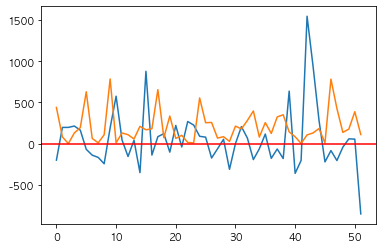

In [188]:
plt.plot(range(len(mc1)), np.abs(mc1["diff"]) - np.abs(mc2["diff"]))
plt.plot(range(len(mc1)), smaller_dif)
plt.axhline(0,color = "red")
# 양수면 lasso가 더 예측못하는 것 

In [217]:
pd.DataFrame(ms).value_counts()

0.0    18
1.0    17
0.5    17
dtype: int64

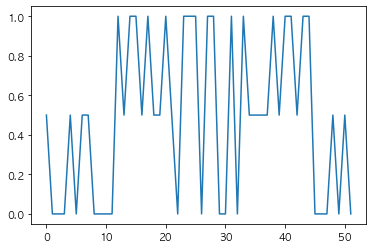

In [263]:
plt.plot(range(len(ms)),ms)

0-11 까지 라쏘, 45-51 까지 라쏘, 12-44까지 캣부

In [219]:
pd.DataFrame(ms)

0
0   0.5
1   0.0
2   0.0
3   0.0
4   0.5
5   0.0
6   0.5
7   0.5
8   0.0
9   0.0
10  0.0
11  0.0
12  1.0
13  0.5
14  1.0
15  1.0
16  0.5
17  1.0
18  0.5
19  0.5
20  1.0
21  0.5
22  0.0
23  1.0
24  1.0
25  1.0
26  0.0
27  1.0
28  1.0
29  0.0
30  0.0
31  1.0
32  0.0
33  1.0
34  0.5
35  0.5
36  0.5
37  0.5
38  1.0
39  0.5
40  1.0
41  1.0
42  0.5
43  1.0
44  1.0
45  0.0
46  0.0
47  0.0
48  0.5
49  0.0
50  0.5
51  0.0

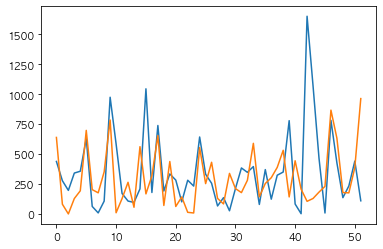

In [191]:
# 파랑색이 lasso
plt.plot(range(len(mc1)), np.abs(mc1["diff"]))
# 주황색이 catboost
plt.plot(range(len(mc2)), np.abs(mc2["diff"]))
plt.show()

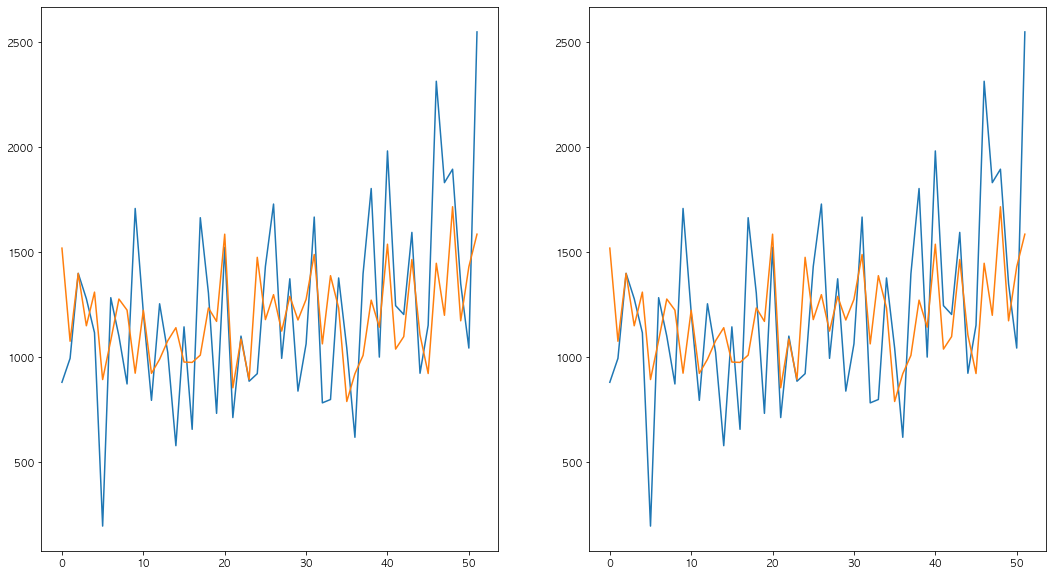

In [192]:
plt.figure(figsize=(18,10))
# Lasso
plt.subplot(1,2,1)
plt.plot(range(len(mc1)),mc1["등록차량수"])
plt.plot(range(len(mc2)),mc2[0])
plt.subplot(1,2,2)
# Catboost
plt.plot(range(len(mc1)),mc1["등록차량수"])
plt.plot(range(len(mc2)),mc2[0])
plt.show()


In [621]:
#Catboost
best_tst_pred1 = pred_down
best_tst_pred3 = pred_up2

col = ["단지코드","공가비율","단지내주차면수","국민임대","임대료","남/여_20~39세","남/여비율","임대보증금","버스정류장","위도","공공임대(단기)","남/여_70세이상","총세대수","총인구수","연면적"]
tst_pred1 = pd.merge(pd.DataFrame(best_tst_pred1,index=[0]).T.reset_index(),
         pd.DataFrame(train_down[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred1 = pd.merge(tst_pred1, pd.concat([train_down.단지코드,train_down['등록차량수']],axis=1), on = "단지코드")
tst_pred3 = pd.merge(tst_pred3, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")

tst_pred1["diff"] = tst_pred1["등록차량수"]-tst_pred1[0]
tst_pred3["diff"] = tst_pred3["등록차량수"]-tst_pred2[0]

q = list(tst_pred1["단지내주차면수"].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
print(q)

q2 = list(tst_pred3["단지내주차면수"].quantile([0,.2,.4,.6,.8,1]))
print(q2)

tst_pred1["realclass"] = [99]*len(tst_pred1)
for i in range(len(q[:-1])):
    tst_pred1.loc[(tst_pred1.단지내주차면수>=q[i])&(tst_pred1.단지내주차면수<q[i+1]),"realclass"] = i
tst_pred1.loc[tst_pred1.단지내주차면수==q[9],"realclass"] = 9

tst_pred1["predclass"] = [99]*len(tst_pred1)
for i in range(len(q[:-1])):
    tst_pred1.loc[(tst_pred1[0]>=q[i])&(tst_pred1[0]<q[i+1]),"predclass"] = i
tst_pred1.loc[tst_pred1[0]==q[9],"predclass"] = 9

tst_pred3["realclass"] = [99]*len(tst_pred3)
for i in range(len(q2[:-1])):
    tst_pred3.loc[(tst_pred3.단지내주차면수>=q2[i])&(tst_pred3.단지내주차면수<q2[i+1]),"realclass"] = i
tst_pred3.loc[tst_pred3.단지내주차면수==q2[5],"realclass"] = 4

tst_pred3["predclass"] = [99]*len(tst_pred3)
for i in range(len(q2[:-1])):
    tst_pred3.loc[(tst_pred3[0]>=q2[i])&(tst_pred3[0]<q2[i+1]),"predclass"] = i
tst_pred3.loc[tst_pred3[0]==q2[5],"predclass"] = 4

from sklearn.metrics import confusion_matrix as cm 
print(cm(tst_pred1.realclass,tst_pred1.predclass))
print(cm(tst_pred3.realclass,tst_pred3.predclass))

[13.0, 166.1, 249.8, 329.29999999999995, 393.0, 451.5, 530.0, 633.0999999999999, 730.4000000000001, 856.6000000000001, 986.0]
[988.0, 1069.2, 1162.8000000000002, 1291.6, 1528.2000000000003, 1798.0]
[[29  7  1  0  0  0  0  0  0  0  0]
 [ 4 18 12  2  0  0  0  0  0  0  0]
 [ 2  3 21  8  2  0  0  0  0  0  0]
 [ 0  2 10 14  7  2  0  0  0  0  0]
 [ 0  0  1  4 10 22  0  0  0  0  0]
 [ 0  0  0  0  1 20 12  1  1  0  0]
 [ 0  0  0  0  1  6 19 10  0  1  0]
 [ 0  0  0  0  0  3 10 19  4  0  0]
 [ 0  0  1  0  0  0  6 15 13  1  0]
 [ 0  0  0  0  0  0  1  9 18  5  2]
 [ 0  0  0  0  0  0  0  0  0  2  0]]
[[0 3 3 3 0 2]
 [2 2 2 0 1 3]
 [0 2 3 3 0 2]
 [2 1 3 1 1 2]
 [1 2 2 3 2 1]
 [0 0 0 0 0 0]]


In [622]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
tst_pred2 = pd.concat([tst_pred2["등록차량수"],tst_pred2.drop(columns = ["index","등록차량수"])],axis=1)

In [623]:
tst_pred2.describe()

등록차량수            0       공가비율      단지내주차면수         국민임대  \
count    52.000000    52.000000  52.000000    52.000000    52.000000   
mean   1218.730769  1166.728448   0.015717  1290.846154   940.980769   
std     447.614072   562.806633   0.010092   241.019842   674.540991   
min     196.000000  -447.317452   0.000000   988.000000     0.000000   
25%     913.000000   821.985651   0.007787  1103.750000     0.000000   
50%    1149.000000  1119.093314   0.014372  1201.500000  1136.500000   
75%    1408.250000  1418.794597   0.022562  1494.750000  1402.750000   
max    2550.000000  2665.276671   0.039446  1798.000000  2334.000000   

                 임대료  남/여_20~39세      남/여비율         임대보증금      버스정류장  \
count      52.000000   52.000000  52.000000  5.200000e+01  52.000000   
mean   256627.873217    1.011276   0.985321  3.409614e+07   3.596154   
std    147571.597430    0.099813   0.043419  2.024493e+07   2.116783   
min     69015.000000    0.872700   0.900000  1.190000e+07   1.000000   
25%    158273.571429    0.950397   0.960000  2.102010e+07   2.000000   
50%    190153.333333    0.992401   0.982500  3.044114e+07   3.000000   
75%    308933.750000    1.057097   1.010000  4.249026e+07   4.000000   
max    575000.000000    1.527082   1.130000  1.330654e+08  10.000000   

               위도     공공임대(단기)  남/여_70세이상         총세대수           총인구수  \
count   52.000000    52.000000  52.000000    52.000000      52.000000   
mean   127.511529   249.596154   0.715235  1350.750000   46680.567308   
std      0.760225   445.930719   0.074331   366.095127   25312.726166   
min    126.574919     0.000000   0.543424   742.000000   11297.000000   
25%    127.087837     0.000000   0.651206  1103.500000   29887.500000   
50%    127.196979     0.000000   0.722142  1323.500000   44766.000000   
75%    127.551463   361.250000   0.765492  1515.000000   54252.000000   
max    129.168440  1444.000000   0.835947  2568.000000  120892.000000   

                연면적         diff  realclass  predclass  
count     52.000000    52.000000  52.000000  52.000000  
mean    5269.423940    52.002321   2.000000  48.730769  
std     5040.337076   474.789969   1.455214  48.851963  
min        8.840000 -1070.276671   0.000000   0.000000  
25%      699.833500  -239.405524   1.000000   2.000000  
50%     6114.313500   -34.439053   2.000000   4.000000  
75%     7265.842376   325.593875   3.000000  99.000000  
max    31427.430000  1651.317452   4.000000  99.000000

In [624]:
# catboost code
tst_pred2.sort_values("등록차량수")

등록차량수            0   단지코드      공가비율  단지내주차면수  국민임대            임대료  \
31   196.0   824.633448  C2362  0.030484   1055.0     0  102500.000000   
47   579.0   788.535123  C2377  0.019910   1110.0  1105  286911.666667   
10   619.0   495.482538  C1176  0.037012   1493.0  1486  178850.000000   
3    657.0   836.281428  C1236  0.025801   1129.0  1124  146470.833333   
37   713.0   814.042259  C2274  0.030303   1182.0  1122  145128.571429   
44   733.0  1067.275569  C1863  0.021838   1154.0   939  157534.285714   
41   783.0  1130.700659  C2618  0.025806   1319.0  1206   92976.000000   
34   795.0   624.080608  C2000  0.016154   1082.0  1300  146071.428571   
24   799.0  1194.612039  C2538  0.008826   1299.0  1459  285076.666667   
23   839.0   812.410828  C1430  0.020874   1296.0  1533  183182.500000   
22   873.0   980.281028  C1672  0.011111   1043.0  1350  229825.000000   
36   881.0  1319.264541  C1286  0.029380    988.0     0  571666.666667   
15   886.0  1118.936704  C1969  0.021230   1192.0  1186  158520.000000   
16   922.0  1564.821251  C2393  0.000647   1176.0  1166  187753.076923   
18   924.0  1389.357969  C1320  0.020637   1648.0  1696  229500.000000   
49   995.0   717.283579  C1357  0.029736   1001.0     0  567500.000000   
1    995.0  1061.825939  C2097  0.029058   1240.0   998  104372.857143   
0   1001.0   221.743578  C1833  0.013930   1505.0  1364  141605.714286   
27  1023.0  1119.249924  C2488  0.023045   1105.0  1215   69015.000000   
26  1044.0  1485.339309  C1177  0.010192   1756.0  1668  188907.500000   
8   1044.0   673.548824  C1451  0.023486   1382.0  1384   88522.000000   
42  1064.0   851.687960  C1407  0.010691   1285.0   914  165956.250000   
28  1101.0  1092.185475  C1677  0.007867   1039.0  1144  274335.454545   
33  1101.0  1382.737926  C1620  0.017857   1181.0  1232  121106.000000   
11  1117.0   760.108029  C2361  0.007666   1026.0  1174  261589.090909   
13  1145.0    99.834541  C1386  0.010020   1100.0  1467   81648.333333   
40  1153.0  1145.040707  C1326  0.022234   1670.0  1934  173800.000000   
51  1204.0  -447.317452  C2446  0.014545   1570.0     0  190920.833333   
45  1214.0   628.749054  C1649  0.029608   1066.0   472  396425.000000   
6   1246.0  1248.052167  C1017  0.018493   1534.0  1460  229706.666667   
17  1255.0  1362.706141  C1065  0.039446   1117.0   938  187376.666667   
4   1279.0   937.447955  C1036  0.017520   1016.0   742  233627.142857   
25  1284.0  1221.224499  C1448  0.022401   1050.0  1116  176717.777778   
2   1306.0  1114.677508  C2046  0.008857   1137.0  1129  211620.000000   
5   1350.0  1583.712325  C1406  0.007893   1741.0  1647  167127.857143   
21  1374.0  1237.838019  C2328  0.003714   1239.0     0  382857.142857   
48  1378.0  1457.468022  C2259  0.005280   1306.0     0  375000.000000   
35  1398.0  1074.460312  C2071  0.014199   1488.0  1346  183177.500000   
30  1400.0  1596.923765  C2496  0.000000    995.0     0  575000.000000   
20  1433.0  1101.243563  C2506  0.012456   1201.0     0  495000.000000   
50  1524.0  1806.839890  C2086  0.006481   1142.0     0  511111.111111   
43  1595.0  2665.276671  C2085  0.006721   1590.0     0  251266.428571   
12  1665.0   926.210428  C1013  0.012232   1119.0  1308  134726.000000   
46  1668.0  1283.790937  C1129  0.001385   1275.0     0  507487.500000   
14  1709.0   734.224845  C2620  0.027211   1061.0     0  523000.000000   
38  1730.0  1986.485119  C1933  0.007828   1202.0     0  544000.000000   
32  1804.0  2154.110006  C1244  0.005807   1483.0  1571  276856.363636   
7   1832.0  1405.903455  C2612  0.016033   1689.0  1684  190500.000000   
9   1896.0  1759.956402  C1939  0.005570   1713.0  2334  189806.666667   
19  1983.0  2065.939793  C1802  0.002086   1500.0     0  466363.636364   
29  2315.0  1532.795854  C1350  0.001428   1636.0     0  417152.360279   
39  2550.0  2659.858249  C1363  0.004283   1798.0  2018  187497.857143   

    남/여_20~39세     남/여비율         임대보증금  버스정류장          위도  공공임대(단기)  \
31    1.012

In [625]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
tst_pred3 = pd.concat([tst_pred3["등록차량수"],tst_pred3.drop(columns = ["index","등록차량수"])],axis=1)

In [626]:
# Lasso code
tst_pred3.sort_values("등록차량수")

등록차량수            0   단지코드      공가비율  단지내주차면수  국민임대            임대료  \
31   196.0   894.053776  C2362  0.030484   1055.0     0  102500.000000   
47   579.0  1141.001748  C2377  0.019910   1110.0  1105  286911.666667   
10   619.0   921.714688  C1176  0.037012   1493.0  1486  178850.000000   
3    657.0   975.686373  C1236  0.025801   1129.0  1124  146470.833333   
37   713.0   854.818720  C2274  0.030303   1182.0  1122  145128.571429   
44   733.0  1171.086274  C1863  0.021838   1154.0   939  157534.285714   
41   783.0  1063.930998  C2618  0.025806   1319.0  1206   92976.000000   
34   795.0   923.522926  C2000  0.016154   1082.0  1300  146071.428571   
24   799.0  1388.824138  C2538  0.008826   1299.0  1459  285076.666667   
23   839.0  1177.756253  C1430  0.020874   1296.0  1533  183182.500000   
22   873.0  1224.735723  C1672  0.011111   1043.0  1350  229825.000000   
36   881.0  1520.049064  C1286  0.029380    988.0     0  571666.666667   
15   886.0   894.151211  C1969  0.021230   1192.0  1186  158520.000000   
16   922.0  1476.257382  C2393  0.000647   1176.0  1166  187753.076923   
18   924.0  1106.438727  C1320  0.020637   1648.0  1696  229500.000000   
49   995.0  1076.364123  C1357  0.029736   1001.0     0  567500.000000   
1    995.0  1124.791922  C2097  0.029058   1240.0   998  104372.857143   
0   1001.0  1143.408345  C1833  0.013930   1505.0  1364  141605.714286   
27  1023.0  1078.910804  C2488  0.023045   1105.0  1215   69015.000000   
26  1044.0  1431.158140  C1177  0.010192   1756.0  1668  188907.500000   
8   1044.0   789.579336  C1451  0.023486   1382.0  1384   88522.000000   
42  1064.0  1275.961602  C1407  0.010691   1285.0   914  165956.250000   
28  1101.0  1277.533798  C1677  0.007867   1039.0  1144  274335.454545   
33  1101.0  1087.320216  C1620  0.017857   1181.0  1232  121106.000000   
11  1117.0  1310.470440  C2361  0.007666   1026.0  1174  261589.090909   
13  1145.0   977.297522  C1386  0.010020   1100.0  1467   81648.333333   
40  1153.0   922.739710  C1326  0.022234   1670.0  1934  173800.000000   
51  1204.0  1098.547944  C2446  0.014545   1570.0     0  190920.833333   
45  1214.0  1224.121725  C1649  0.029608   1066.0   472  396425.000000   
6   1246.0  1039.101124  C1017  0.018493   1534.0  1460  229706.666667   
17  1255.0   990.601102  C1065  0.039446   1117.0   938  187376.666667   
4   1279.0  1150.239558  C1036  0.017520   1016.0   742  233627.142857   
25  1284.0  1080.743884  C1448  0.022401   1050.0  1116  176717.777778   
2   1306.0  1235.029555  C2046  0.008857   1137.0  1129  211620.000000   
5   1350.0  1173.873141  C1406  0.007893   1741.0  1647  167127.857143   
21  1374.0  1290.174329  C2328  0.003714   1239.0     0  382857.142857   
48  1378.0  1234.997982  C2259  0.005280   1306.0     0  375000.000000   
35  1398.0  1009.018426  C2071  0.014199   1488.0  1346  183177.500000   
30  1400.0  1399.653437  C2496  0.000000    995.0     0  575000.000000   
20  1433.0  1179.568243  C2506  0.012456   1201.0     0  495000.000000   
50  1524.0  1586.497759  C2086  0.006481   1142.0     0  511111.111111   
43  1595.0  1465.747690  C2085  0.006721   1590.0     0  251266.428571   
12  1665.0  1010.336414  C1013  0.012232   1119.0  1308  134726.000000   
46  1668.0  1489.750262  C1129  0.001385   1275.0     0  507487.500000   
14  1709.0   924.318940  C2620  0.027211   1061.0     0  523000.000000   
38  1730.0  1298.395936  C1933  0.007828   1202.0     0  544000.000000   
32  1804.0  1272.305314  C1244  0.005807   1483.0  1571  276856.363636   
7   1832.0  1200.097016  C2612  0.016033   1689.0  1684  190500.000000   
9   1896.0  1717.256175  C1939  0.005570   1713.0  2334  189806.666667   
19  1983.0  1538.703669  C1802  0.002086   1500.0     0  466363.636364   
29  2315.0  1447.968148  C1350  0.001428   1636.0     0  417152.360279   
39  2550.0  1586.515107  C1363  0.004283   1798.0  2018  187497.857143   

    남/여_20~39세     남/여비율         임대보증금  버스정류장          위도  공공임대(단기)  \
31    1.012

<AxesSubplot:xlabel='diff', ylabel='Density'>

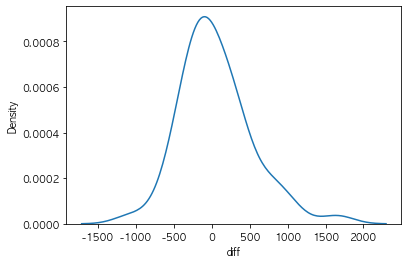

In [579]:
sns.kdeplot(data = tst_pred3,  x = "diff")

<AxesSubplot:xlabel='diff', ylabel='Density'>

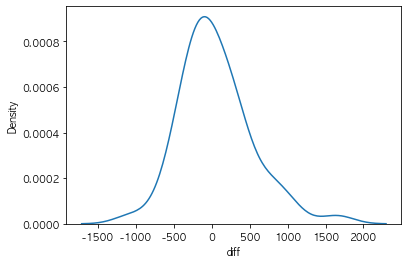

In [578]:
sns.kdeplot(data = tst_pred2,  x = "diff")

In [554]:
tst_pred2.describe()

등록차량수            0       공가비율      단지내주차면수         국민임대  \
count    52.000000    52.000000  52.000000    52.000000    52.000000   
mean   1218.730769  1189.867824   0.015717  1290.846154   940.980769   
std     447.614072   216.270309   0.010092   241.019842   674.540991   
min     196.000000   789.579336   0.000000   988.000000     0.000000   
25%     913.000000  1031.909947   0.007787  1103.750000     0.000000   
50%    1149.000000  1172.479708   0.014372  1201.500000  1136.500000   
75%    1408.250000  1301.414562   0.022562  1494.750000  1402.750000   
max    2550.000000  1717.256175   0.039446  1798.000000  2334.000000   

                 임대료  남/여_20~39세      남/여비율         임대보증금      버스정류장  \
count      52.000000   52.000000  52.000000  5.200000e+01  52.000000   
mean   256627.873217    1.011276   0.985321  3.409614e+07   3.596154   
std    147571.597430    0.099813   0.043419  2.024493e+07   2.116783   
min     69015.000000    0.872700   0.900000  1.190000e+07   1.000000   
25%    158273.571429    0.950397   0.960000  2.102010e+07   2.000000   
50%    190153.333333    0.992401   0.982500  3.044114e+07   3.000000   
75%    308933.750000    1.057097   1.010000  4.249026e+07   4.000000   
max    575000.000000    1.527082   1.130000  1.330654e+08  10.000000   

               위도     공공임대(단기)  남/여_70세이상         총세대수           총인구수  \
count   52.000000    52.000000  52.000000    52.000000      52.000000   
mean   127.511529   249.596154   0.715235  1350.750000   46680.567308   
std      0.760225   445.930719   0.074331   366.095127   25312.726166   
min    126.574919     0.000000   0.543424   742.000000   11297.000000   
25%    127.087837     0.000000   0.651206  1103.500000   29887.500000   
50%    127.196979     0.000000   0.722142  1323.500000   44766.000000   
75%    127.551463   361.250000   0.765492  1515.000000   54252.000000   
max    129.168440  1444.000000   0.835947  2568.000000  120892.000000   

                연면적        diff  realclass  predclass  
count     52.000000   52.000000  52.000000  52.000000  
mean    5269.423940   28.862945   2.000000  20.615385  
std     5040.337076  380.592767   1.455214  38.635123  
min        8.840000 -698.053776   0.000000   0.000000  
25%      699.833500 -198.093231   1.000000   1.000000  
50%     6114.313500    7.013174   2.000000   2.000000  
75%     7265.842376  212.739229   3.000000   4.000000  
max    31427.430000  963.484893   4.000000  99.000000

## 4. Final prediction

In [457]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [458]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [459]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [476]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']

In [471]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up1 = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
pred_up1 = cb_up.predict(X_test)

In [474]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV

In [473]:
from sklearn.preprocessing import StandardScaler
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
cb_up2 =  ElasticNet(random_state=2021).fit(X_train,y_train)
pred_up2 = cb_up2.predict(X_test)

In [485]:
from sklearn.preprocessing import StandardScaler
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
cb_up =  Lasso(random_state=2021).fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [486]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

In [483]:
def get_pred2():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up2 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

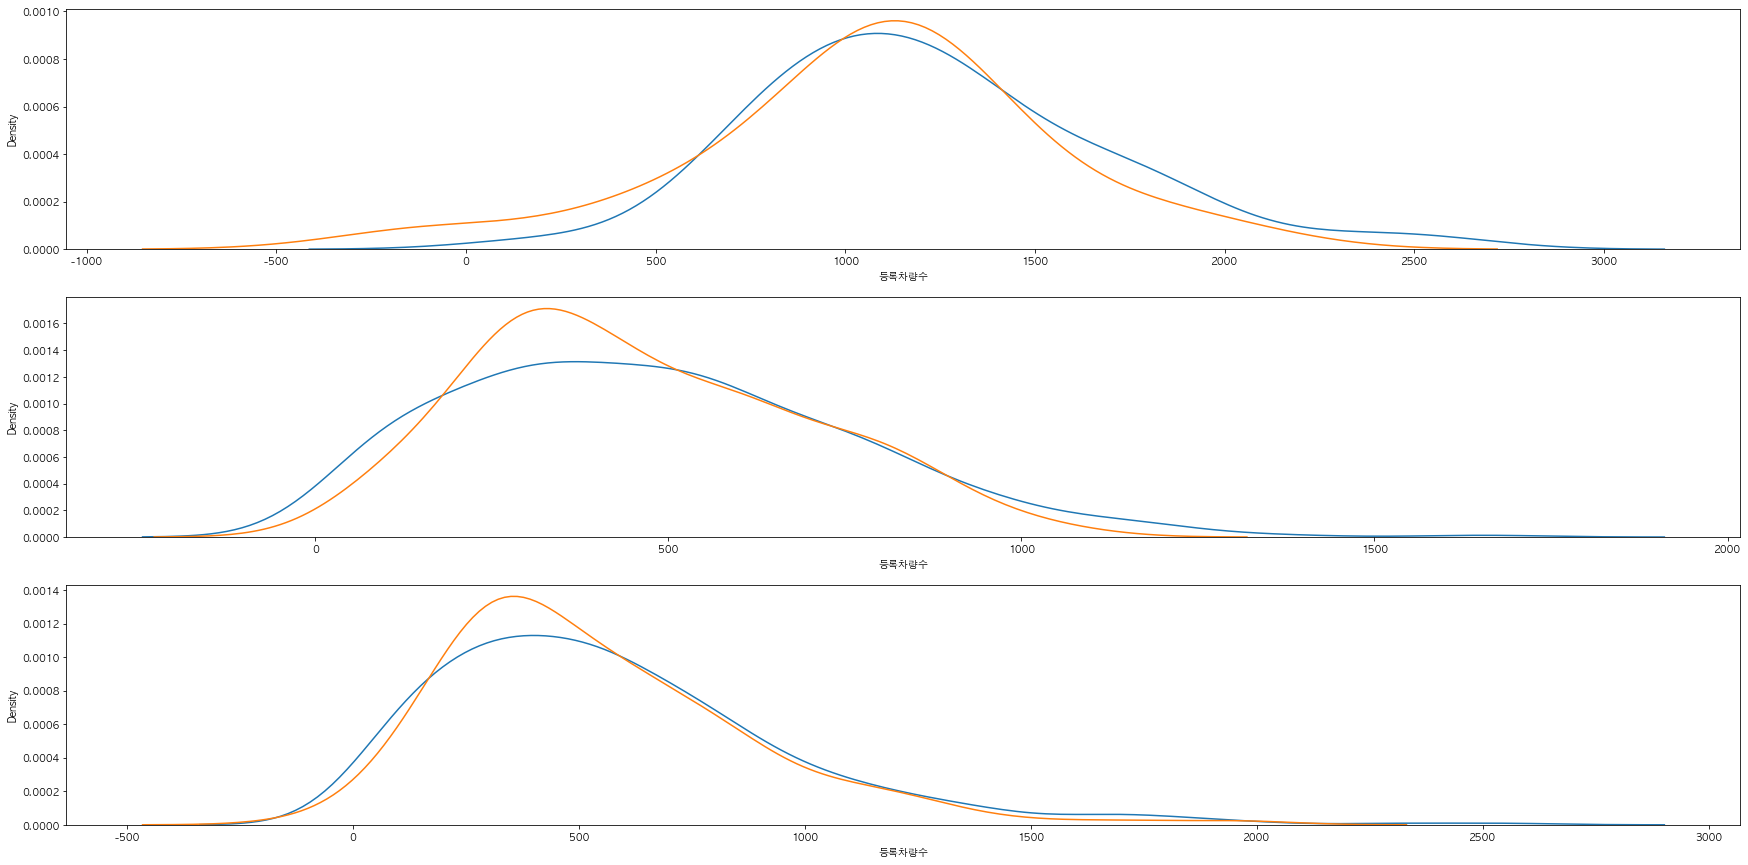

In [487]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

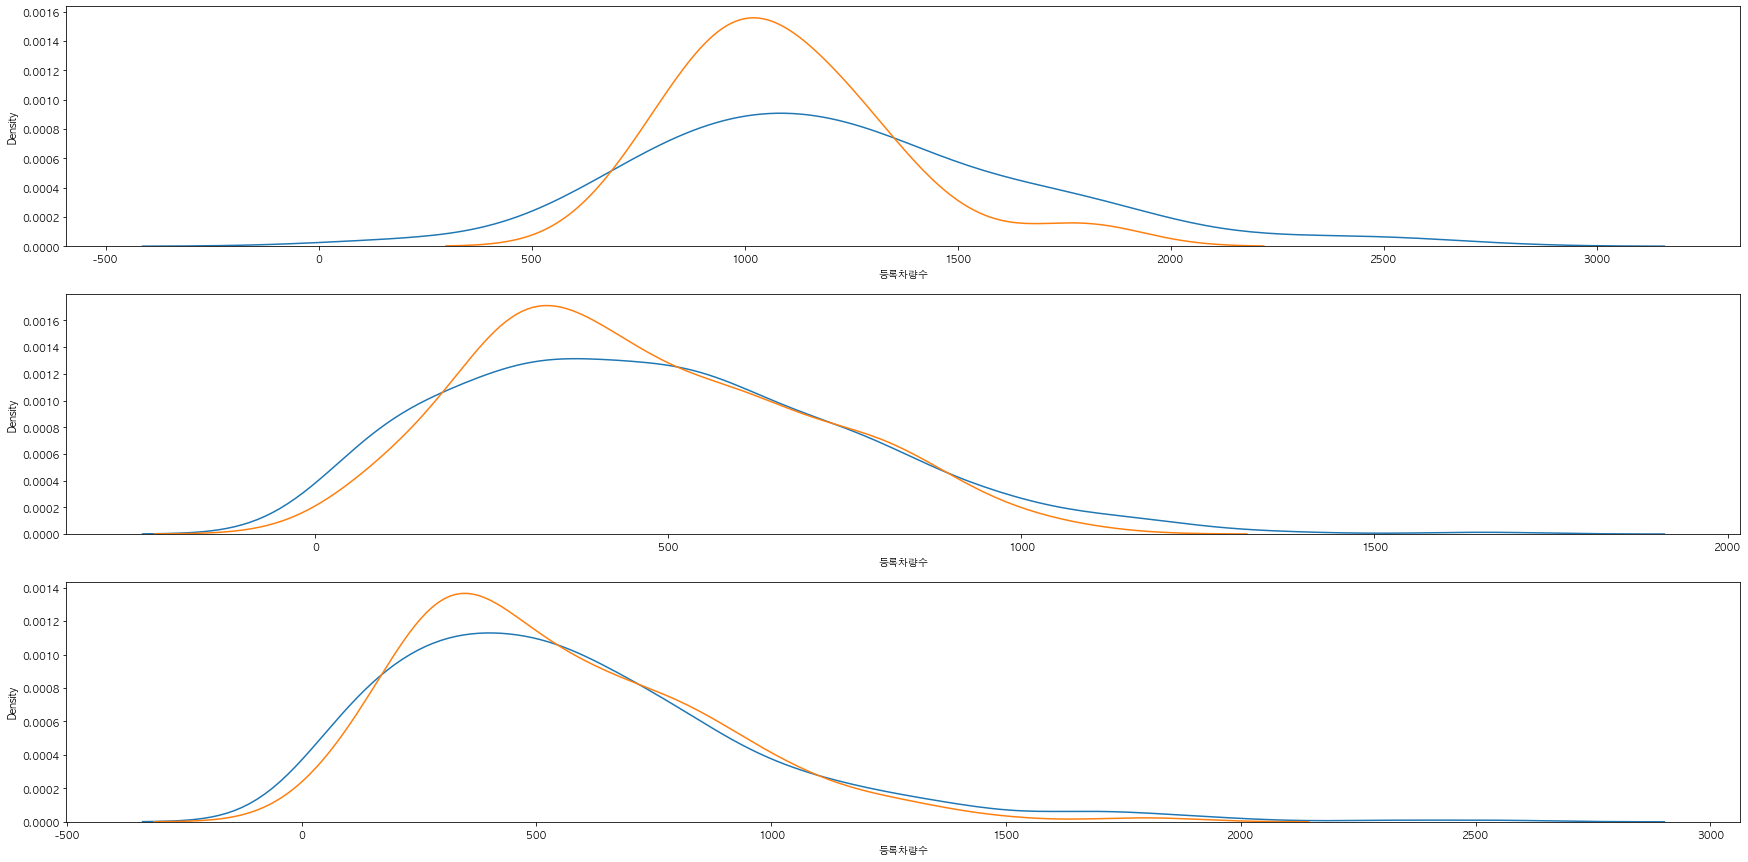

In [305]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

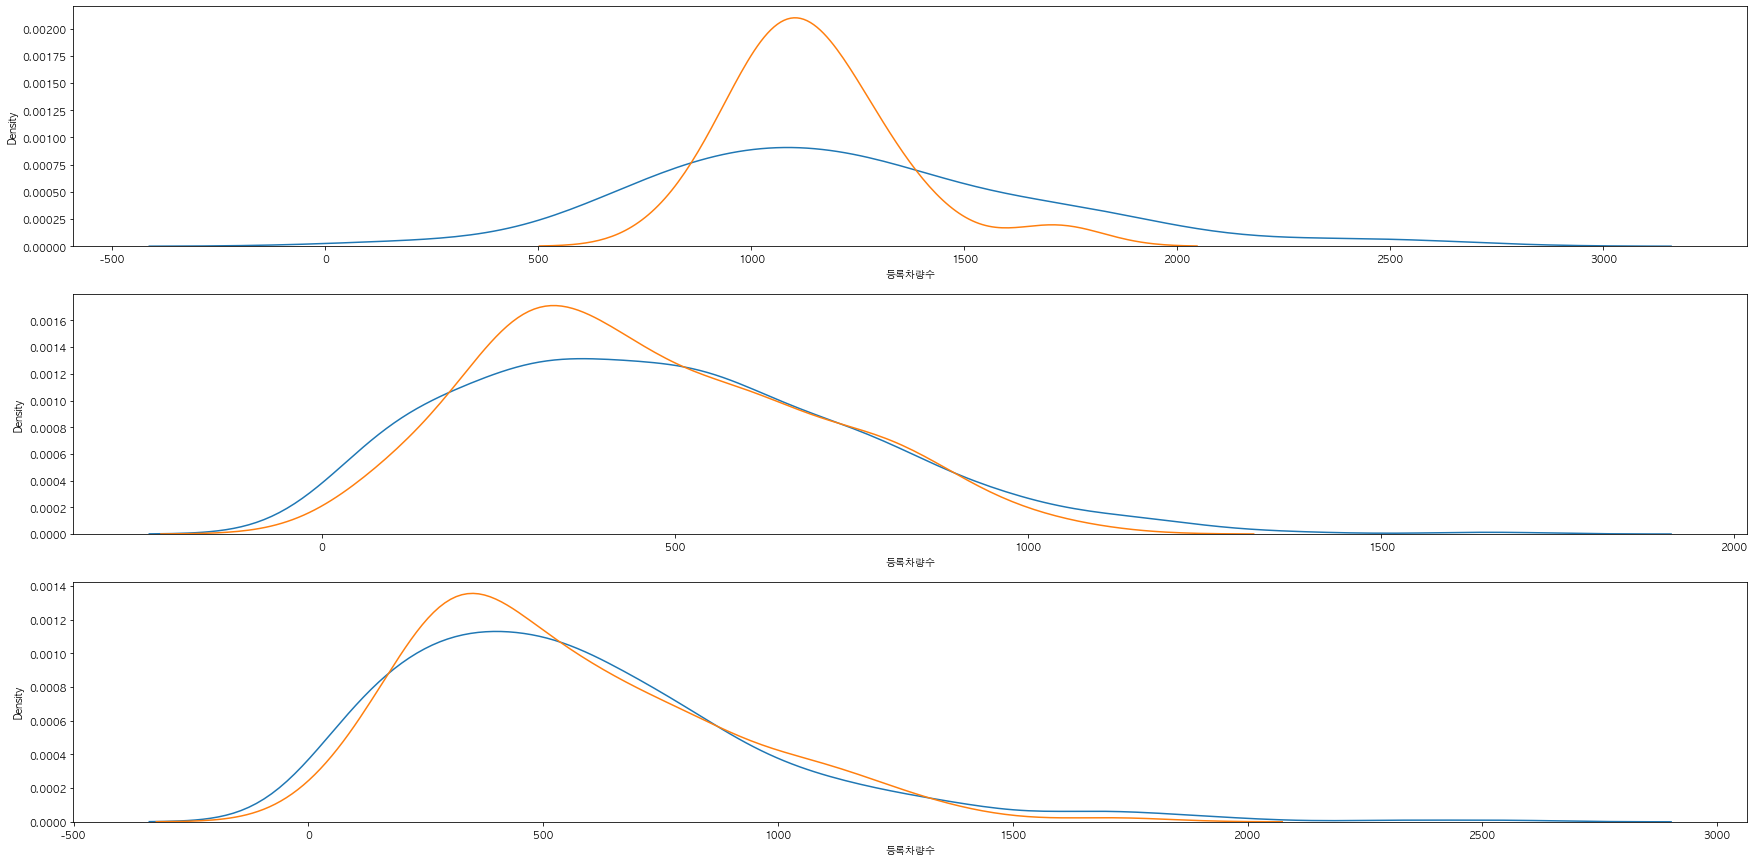

In [245]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

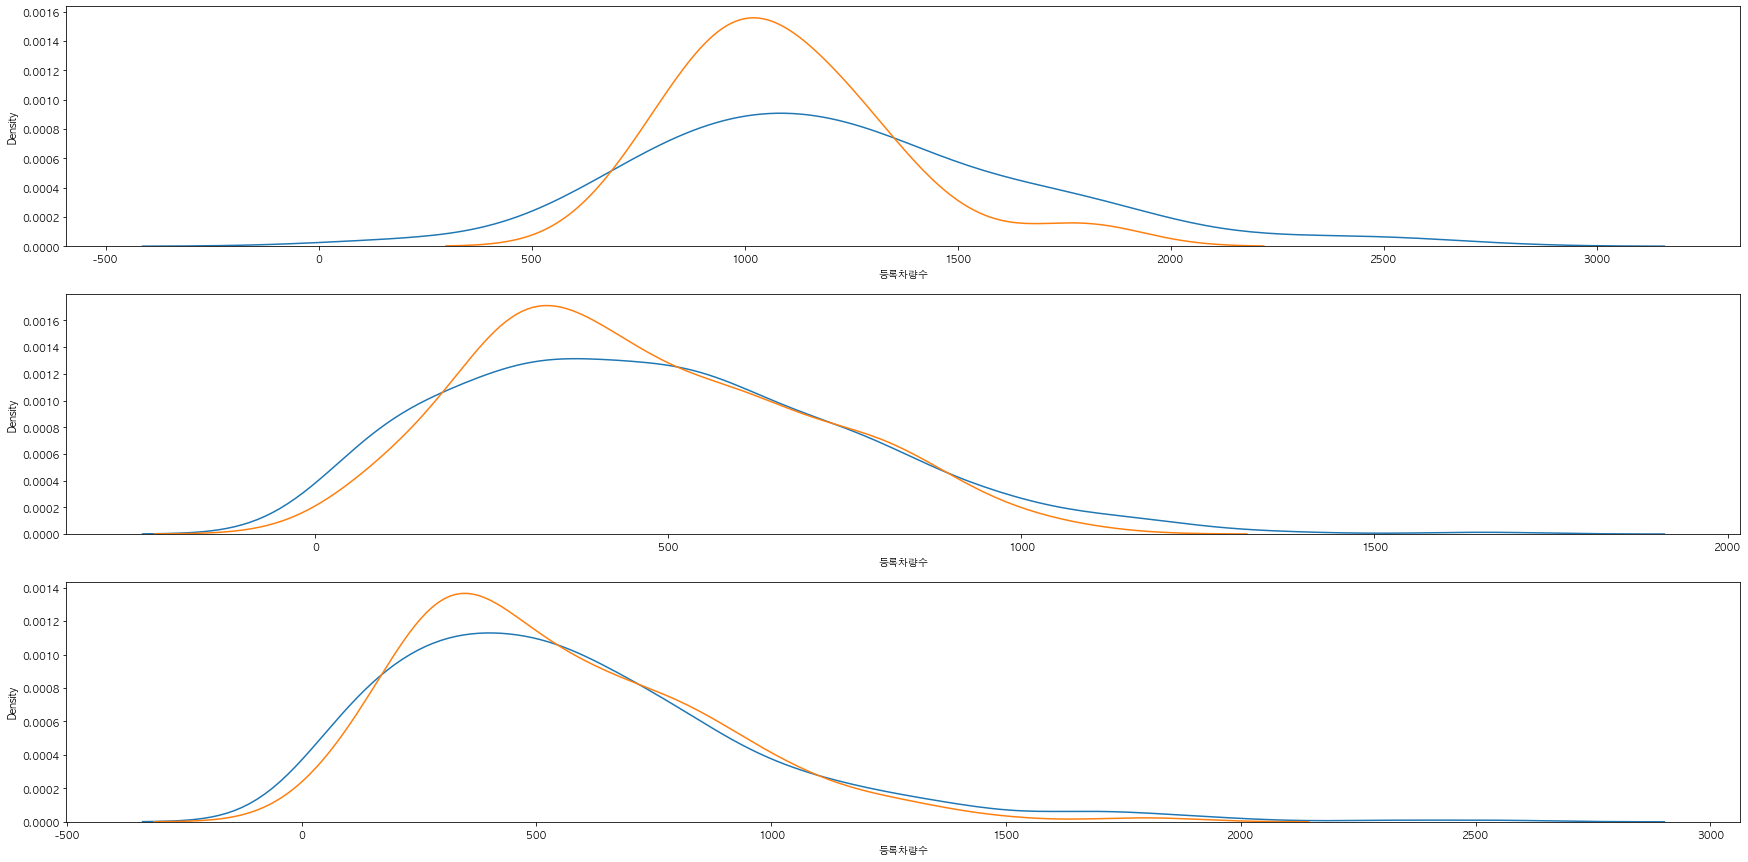

In [239]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

## 5. 기존 score와 비교 및 제출

In [464]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [465]:
sub = submit()
sub.to_csv("result/result.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'result/result.csv'

In [466]:
def score(mse):
    score = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [467]:
score(96)

전체 MAE :  29.4503628316427
큰 영역 MAE :  117.9199920247777
작은 영역 MAE :  16.318152248286715


code        num_x        num_y
0    C1072   751.540951   757.743865
1    C1456   539.409116   570.896549
2    C1840   533.220234   545.578549
3    C1640   464.134797   449.874695
4    C1377   364.187487   351.579558
5    C2072   309.466838   302.111860
6    C1472   482.488348   481.050094
7    C1006   224.868781   248.765433
8    C1083   416.066054   399.663404
9    C1311   249.035706   257.260172
10   C2676   282.868356   285.900288
11   C2318   247.928124   254.694920
12   C1603   489.814280   494.572512
13   C2523   378.004362   355.185299
14   C2177   192.902211   182.621371
15   C2411   726.549416   723.869224
16   C2033   243.508656   268.025406
17   C1604   355.333903   409.823746
18   C2535   402.544583   409.804347
19   C1040   390.839841   410.999664
20   C2417   351.634871   331.295099
21   C1812   143.347119   175.235480
22   C2253   102.334557   118.653429
23   C1294   549.358530   546.571642
24   C1772   510.003303   528.407536
25   C2646   474.115703   453.905783
26   C2423   165.811532   195.155607
27   C1844   492.002114   473.433358
28   C1318   229.303896   225.971230
29   C1729    83.557119    86.803051
30   C1602   303.228741   299.727041
31   C1239   344.414242   356.677193
32   C1721   592.738822   594.636528
33   C1902   807.677902   830.127148
34   C1855   254.617162   257.213449
35   C2600   375.943969   383.256794
36   C1071   471.015836   474.291760
37   C2295   452.976992   462.306590
38   C1621   587.559275   586.201407
39   C1852   873.331171   853.237146
40   C1297   476.378032   474.952460
41   C2323   578.167728   612.955114
42   C2215   411.123436   398.979652
43   C2112   416.226025   424.025877
44   C1830   784.323913   810.613947
45   C2602   322.333700   309.413493
46   C1215   621.311036   643.851153
47   C2369   619.814162   622.656209
48   C1158   264.391941   257.877375
49   C1887   637.854830   617.465385
50   C1189   284.261903   252.915115
51   C1637   444.249636   412.175966
52   C1225   118.235856   112.171609
53   C2374   295.211186   308.028399
54   C2397   559.248149   587.124592
55   C1105   781.358071   815.086570
56   C1782   377.063477   389.621275
57   C1629   170.848293   182.181604
58   C1708   311.180658   300.730751
59   C2144   406.120550   414.046394
60   C1149   467.243227   442.439379
61   C1323   354.818246   320.333648
62   C1064   757.383224   709.120274
63   C1019   294.479200   290.048625
64   C2269   673.829027   707.964851
65   C1416   888.121621   903.709383
66   C1741   439.502064   443.930765
67   C1016   697.591398   681.117775
68   C2436   610.987638   604.355859
69   C2039   937.162426   932.150131
70   C1253   911.685113   912.960811
71   C1166   290.630300   345.282833
72   C1135   300.647996   289.341318
73   C1216   344.415041   346.662129
74   C1593   309.489678   310.771712
75   C1826   251.825360   259.672769
76   C1827   414.697677   427.388714
77   C1564   262.456206   261.539078
78   C2653   817.431918   810.912996
79   C1392   676.294574   697.111966
80   C2128   321.734532   314.980911
81   C1282   617.365636   606.495204
82   C1060   616.541349   624.872684
83   C2557   799.149164   831.979780
84   C1835   819.455133   800.813585
85   C2224   736.078935   707.475293
86   C2222   368.596576   393.160816
87   C2430   808.998690   792.513261
88   C2497   735.410641   749.662413
89   C1494  1026.260657   998.924905
90   C1457   632.087370   643.364654
91   C1712   589.402876   597.345880
92   C1623   313.815759   288.735620
93   C2131   582.598373   563.637141
94   C2691  1085.935364  1058.175661
95   C1147   734.347670   780.787668
96   C1474   179.499051   181.080995
97   C1633   112.231904   121.029168
98   C2113   569.528241   607.843901
99   C2175   930.193672   916.520628
100  C2547   570.194395   601.431190
101  C2292   755.278413   800.327925
102  C1496   760.825381   740.312736
103  C1289   363.171720   348.774314
104  C1849   750.566995   797.472842
105  C1003   253.632301   265.150365
106  C2268   370.708532   352.198764
107  C2551

In [ ]:
res2 = score(96)

In [ ]:
res1 = score(98)

In [ ]:
res3 = score(99)

In [ ]:
res4 = score(100)